## Libraries

In [61]:
import sys, os
sys.path.append('../utils')

from imp import reload
import preprocessing; reload(preprocessing)

from preprocessing import ImageProcessor, DatasetProcessor
from preprocessing import Analytics

import matplotlib.pyplot as plt
import numpy as np
import random
import math
import os
from PIL import Image

try:
    from sklearn.cross_validation import train_test_split
except ImportError:
    from sklearn.model_selection import train_test_split  


import tensorflow as tf
import tensorflow.contrib.layers as layers

%matplotlib inline

## Split dataset

In [111]:
#DatasetProcessor.file_train_test_split()

## Const params

In [2]:
image_size = 128
SEED = 42
TRAIN_PATH = '../input/train/'
VALIDATE_PATH = '../input/validation/'

random.seed(SEED)
tf.set_random_seed(SEED)

## Load the data

In [3]:
wnids_train = DatasetProcessor.get_dataset_wnids(dataset_dir=TRAIN_PATH)
wnids_test = DatasetProcessor.get_dataset_wnids(dataset_dir=VALIDATE_PATH)

In [4]:
wnid_to_lable = DatasetProcessor.get_wnid_table()

train = DatasetProcessor.get_dataset_paths_from_wnid(wnids_train, dataset_path=TRAIN_PATH)
test = DatasetProcessor.get_dataset_paths_from_wnid(wnids_test, dataset_path=VALIDATE_PATH)

## Transform data and create consts

In [5]:
wnid_to_one_hot = DatasetProcessor.wnid_to_one_hot(wnids_train)
lables = sorted(wnid_to_one_hot.keys())

In [6]:
y_train = DatasetProcessor.paths_to_one_hot(train, wnid_to_one_hot)
y_test = DatasetProcessor.paths_to_one_hot(test, wnid_to_one_hot)

In [7]:
TRAIN_SIZE = len(train)
TEST_SIZE = len(test)

## Exploritory analysis

In [8]:
print ('Train size:', len(train))
print ('Test size:', len(test))
print ('Class number:', len(wnids_train))

Train size: 14928
Test size: 1649
Class number: 15


In [49]:
wnids_train = sorted(wnids_train)
print(wnids_train)

['n01493146', 'n01495006', 'n01859496', 'n01860002', 'n01860187', 'n02058594', 'n02058747', 'n02114712', 'n02119477', 'n02133704', 'n02134084', 'n02165877', 'n02166229', 'n02166567', 'n02166826']


In [50]:
classes = [wnid_to_lable[wnid] for wnid in wnids_train]
print ('Lables:', classes)

Lables: ['whitetip shark, reef whitetip shark, Triaenodon obseus', 'shovelhead, bonnethead, bonnet shark, Sphyrna tiburo', 'tundra swan, Cygnus columbianus', 'trumpeter, trumpeter swan, Cygnus buccinator', 'black swan, Cygnus atratus', 'wandering albatross, Diomedea exulans', 'black-footed albatross, gooney, gooney bird, goonie, goony, Diomedea nigripes', 'red wolf, maned wolf, Canis rufus, Canis niger', 'red fox, Vulpes fulva', 'Asiatic black bear, black bear, Ursus thibetanus, Selenarctos thibetanus', 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus', 'two-spotted ladybug, Adalia bipunctata', 'Mexican bean beetle, bean beetle, Epilachna varivestis', 'Hippodamia convergens', 'vedalia, Rodolia cardinalis']


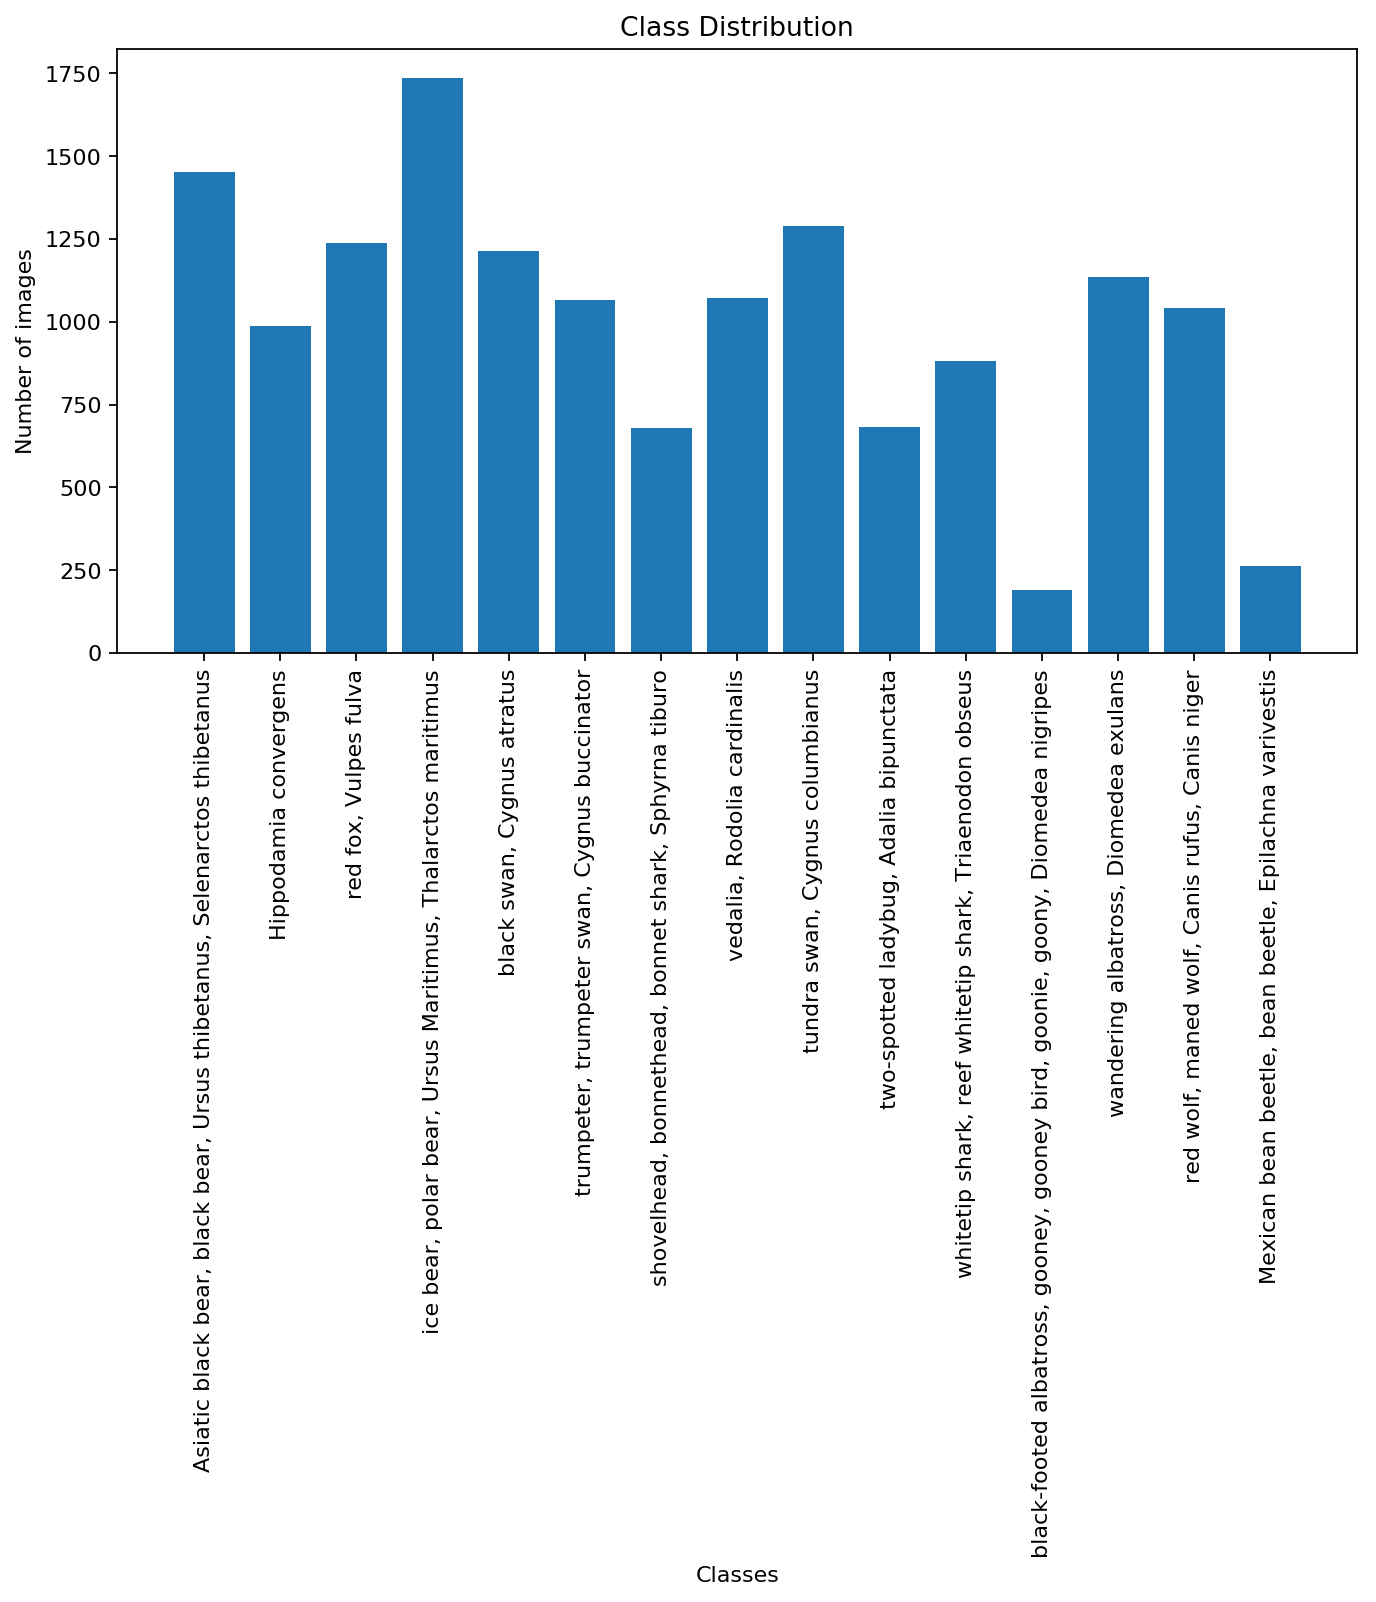

In [10]:
ImageProcessor.set_image_size(10, 5)
class_distribution = Analytics.extract_class_distribution(train)
classes = map(lambda x: wnid_to_lable[x], class_distribution.keys())

plt.bar(range(len(class_distribution)), class_distribution.values(), align='center')
plt.xticks(range(len(class_distribution)), classes, rotation='vertical')
plt.title('Class Distribution')
plt.ylabel('Number of images')
plt.xlabel('Classes')
plt.show()

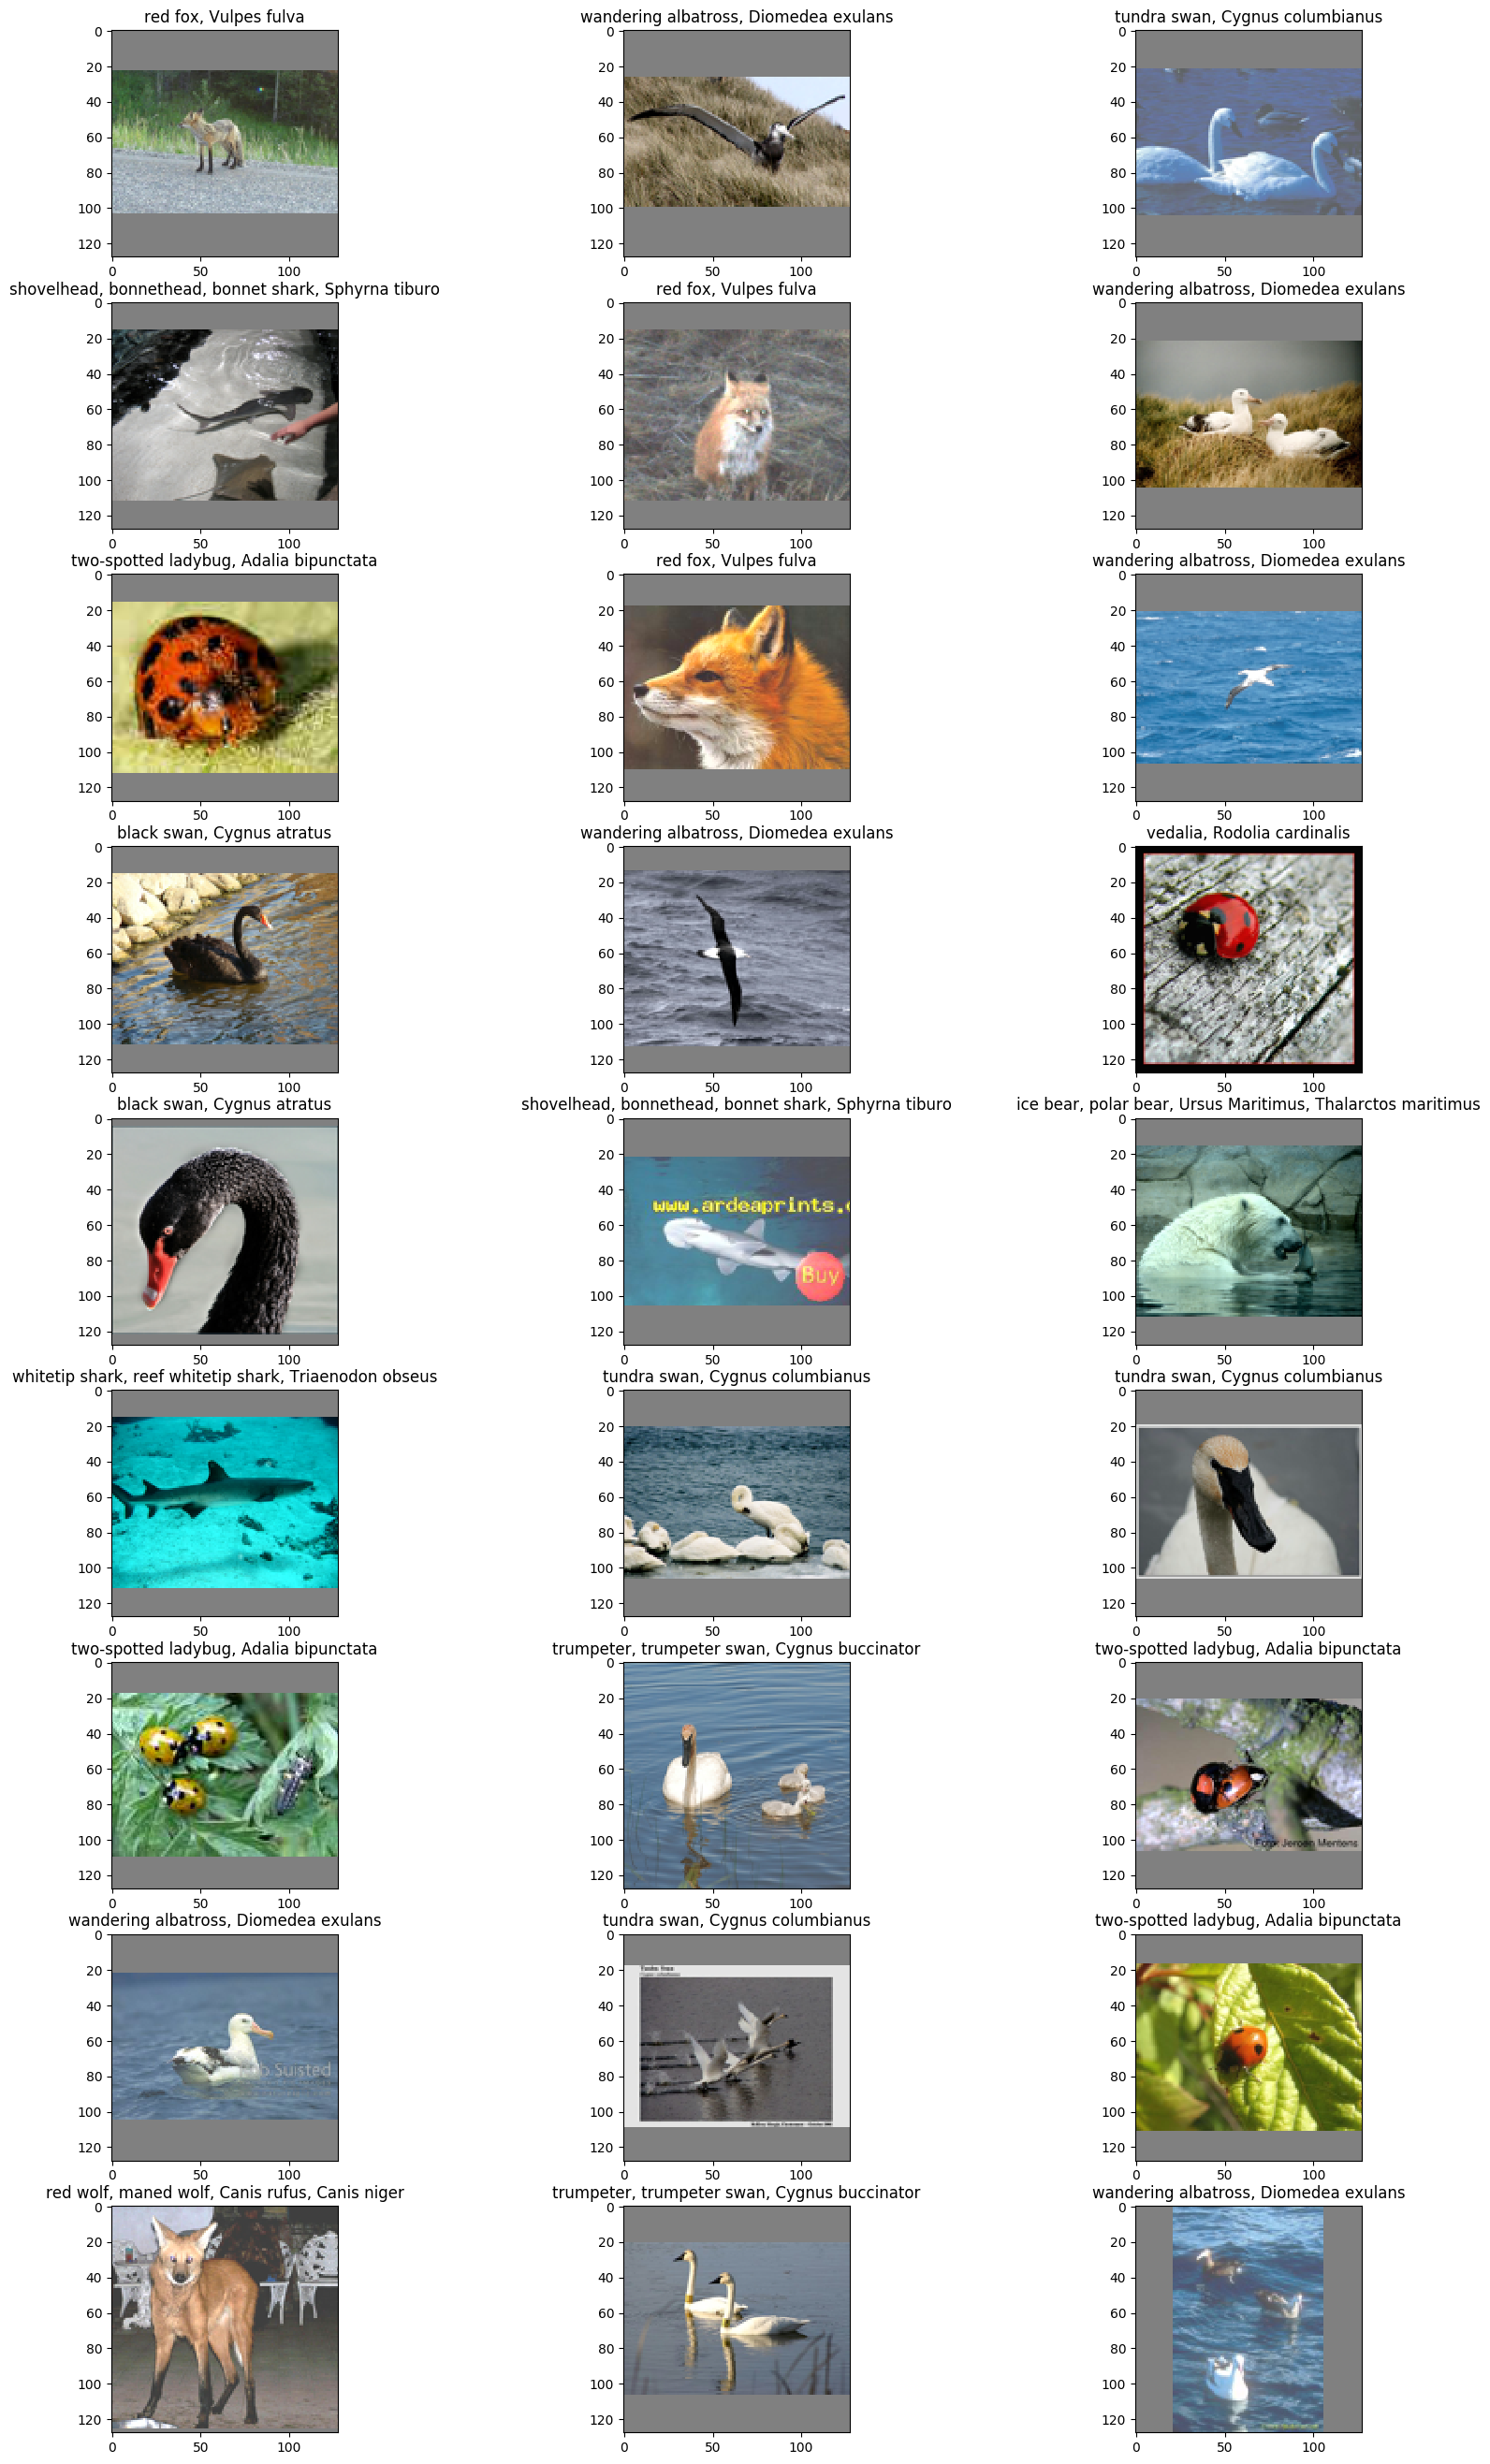

In [11]:
ImageProcessor.set_image_size(20, 34, 100)

for i in range(1, 28):
    plt.subplot(9, 3, i)
    
    random_index = np.random.randint(0, len(train))
    image_path = train[random_index]
    image = ImageProcessor.get_image(image_path)

    processed_image = ImageProcessor.get_processed_image(image, size=image_size)
    
    wnid = DatasetProcessor.extract_wnid(image_path)
    plt.title(wnid_to_lable[wnid])
    
    plt.imshow(processed_image)
    
    
plt.show()

## Data jittering

In [12]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [13]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

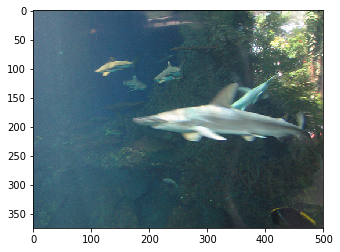

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [14]:
random_index = np.random.randint(0, len(train))
image_path = train[random_index]

img = load_img(image_path)  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory

plt.imshow(img)
plt.show()

i = 0
ImageProcessor.set_image_size(20, 34, 100)
for batch in datagen.flow(x, batch_size=1):
    i += 1

    plt.subplot(9, 3, i)
    plt.imshow(batch[0,:,:,:])
        
    if i > 17:
        break  # otherwise the generator would loop indefinitely

## Baseline convnet

In [ ]:
#import fileupload
#fileupload.nbinstall()

# Run in keras docker
# jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [ ]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, BatchNormalization, Input

from keras_tqdm import TQDMNotebookCallback
from keras.models import model_from_json, Model, Sequential

from keras import backend as K
K.set_image_dim_ordering('tf')

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

In [ ]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
batch_size = 64

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../input/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../input/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=14929 // batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=1649  // batch_size,
        verbose=0,
        callbacks=[TQDMNotebookCallback()])

model.save_weights('shallow_model.h5')  # always save your weights after training or during training

## Deeper model

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../input/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        classes=classes
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../input/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        classes=classes
        class_mode='categorical')

In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=14929 // batch_size,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=1649  // batch_size,
        verbose=0,
        callbacks=[TQDMNotebookCallback()])

model.save_weights('deeper_model.h5')  # always save your weights after training or during training

## Deeper model + batch norm + agressive jittering

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(15, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../input/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../input/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=14929 // batch_size,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=1649  // batch_size,
        verbose=0,
        callbacks=[TQDMNotebookCallback()])

model.save_weights('batch_norm.h5')  # always save your weights after training or during training

## ResNet

In [15]:
from keras.applications import ResNet50
from keras.layers import Input, Dense, Flatten, BatchNormalization, Activation, Dropout
from keras.models import Sequential, Model, load_model
from keras_tqdm import TQDMNotebookCallback
from keras.optimizers import Adam, Adamax, RMSprop

from sklearn.metrics import f1_score, recall_score, precision_score, log_loss, accuracy_score

In [16]:
IMG_DIM = 224
INPUT_TENSOR = Input(shape=(IMG_DIM, IMG_DIM, 3))

base_model = ResNet50(input_tensor=INPUT_TENSOR, include_top=False)

In [17]:
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 230, 230, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472                                         
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256                                          
___________________________________________________________________________________________

In [18]:
for layer in base_model.layers:
    layer.trainable = False

In [100]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))

top_model.add(Dense(512))
top_model.add(BatchNormalization())
top_model.add(Activation('relu'))
top_model.add(Dropout(0.3))

top_model.add(Dense(512))
top_model.add(BatchNormalization())
top_model.add(Activation('relu'))

top_model.add(Dense(15, activation='softmax'))

In [101]:
model = Model(input= base_model.input, output= top_model(base_model.output))

#for layer in model.layers[:-8]:
#    layer.trainable = False

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [22]:
batch_size = 16
TRAIN_STEPS = math.ceil(TRAIN_SIZE / batch_size)
VALIDATION_STEPS = math.ceil(TEST_SIZE / batch_size)

print(TRAIN_STEPS, VALIDATION_STEPS)

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../input/train',  # this is the target directory
        target_size=(IMG_DIM, IMG_DIM),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../input/validation',
        target_size=(IMG_DIM, IMG_DIM),
        batch_size=batch_size,
        class_mode='categorical')

933 104
Found 14928 images belonging to 15 classes.
Found 1649 images belonging to 15 classes.


In [19]:
#model = load_model('FineTunedResNet.h5')

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [94]:
model.fit_generator(
        train_generator,
        steps_per_epoch=TRAIN_STEPS,
        epochs=9,
        validation_data=validation_generator,
        validation_steps=VALIDATION_STEPS,
        verbose=0,
        callbacks=[TQDMNotebookCallback()])

/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 959512576 bytes but only got 0. Skipping tag 0
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19600506880 bytes but only got 0. Skipping tag 0
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 48
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 791347200 bytes but only got 0. Skipping tag 0
  "Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 12 

In [ ]:
#model.save('FineTunedResNet.h5')

In [25]:
metric_validation_generator = test_datagen.flow_from_directory(
        '../input/validation',
        target_size=(IMG_DIM, IMG_DIM),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        classes=lables)

metric_validation_generator.reset()
y_pred = model.predict_generator(metric_validation_generator, VALIDATION_STEPS)
y_pred = DatasetProcessor.softmax_predictions_to_one_hot(y_pred)

print(y_pred.shape)

y_test = []
metric_validation_generator.reset()
for validation_touple in metric_validation_generator:
    X_test_batch, y_pred_batch = validation_touple
    y_test.extend(y_pred_batch)
    
    if metric_validation_generator.batch_index == 0:
        break
    
y_test = np.array(y_test)
print(y_test.shape)

Found 1649 images belonging to 15 classes.
(1649, 15)
(1649, 15)


In [26]:
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
acc = accuracy_score(y_test, y_pred, 'macro')

print('Recall:', recall)
print('Precison:', precision)
print('F1:', f1)
print('Acc:', acc)

Recall: 0.802116509168
Precison: 0.808565642959
F1: 0.803119573865
Acc: 0.835051546392


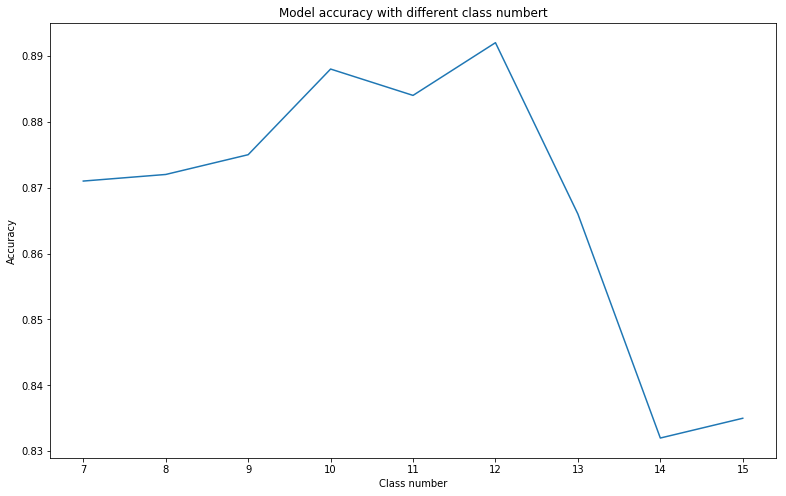

In [40]:
class_num = [15, 14, 13, 12, 11, 10, 9, 8, 7]
acc = [0.835, 0.832, 0.866, 0.892, 0.884, 0.888, 0.875, 0.872,  0.871]

ImageProcessor.set_image_size(13, 8, 72)
plt.plot(class_num, acc)
plt.title('Model accuracy with different class numbert')
plt.xlabel('Class number')
plt.ylabel('Accuracy')
plt.show()

In [29]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Confusion matrix, without normalization


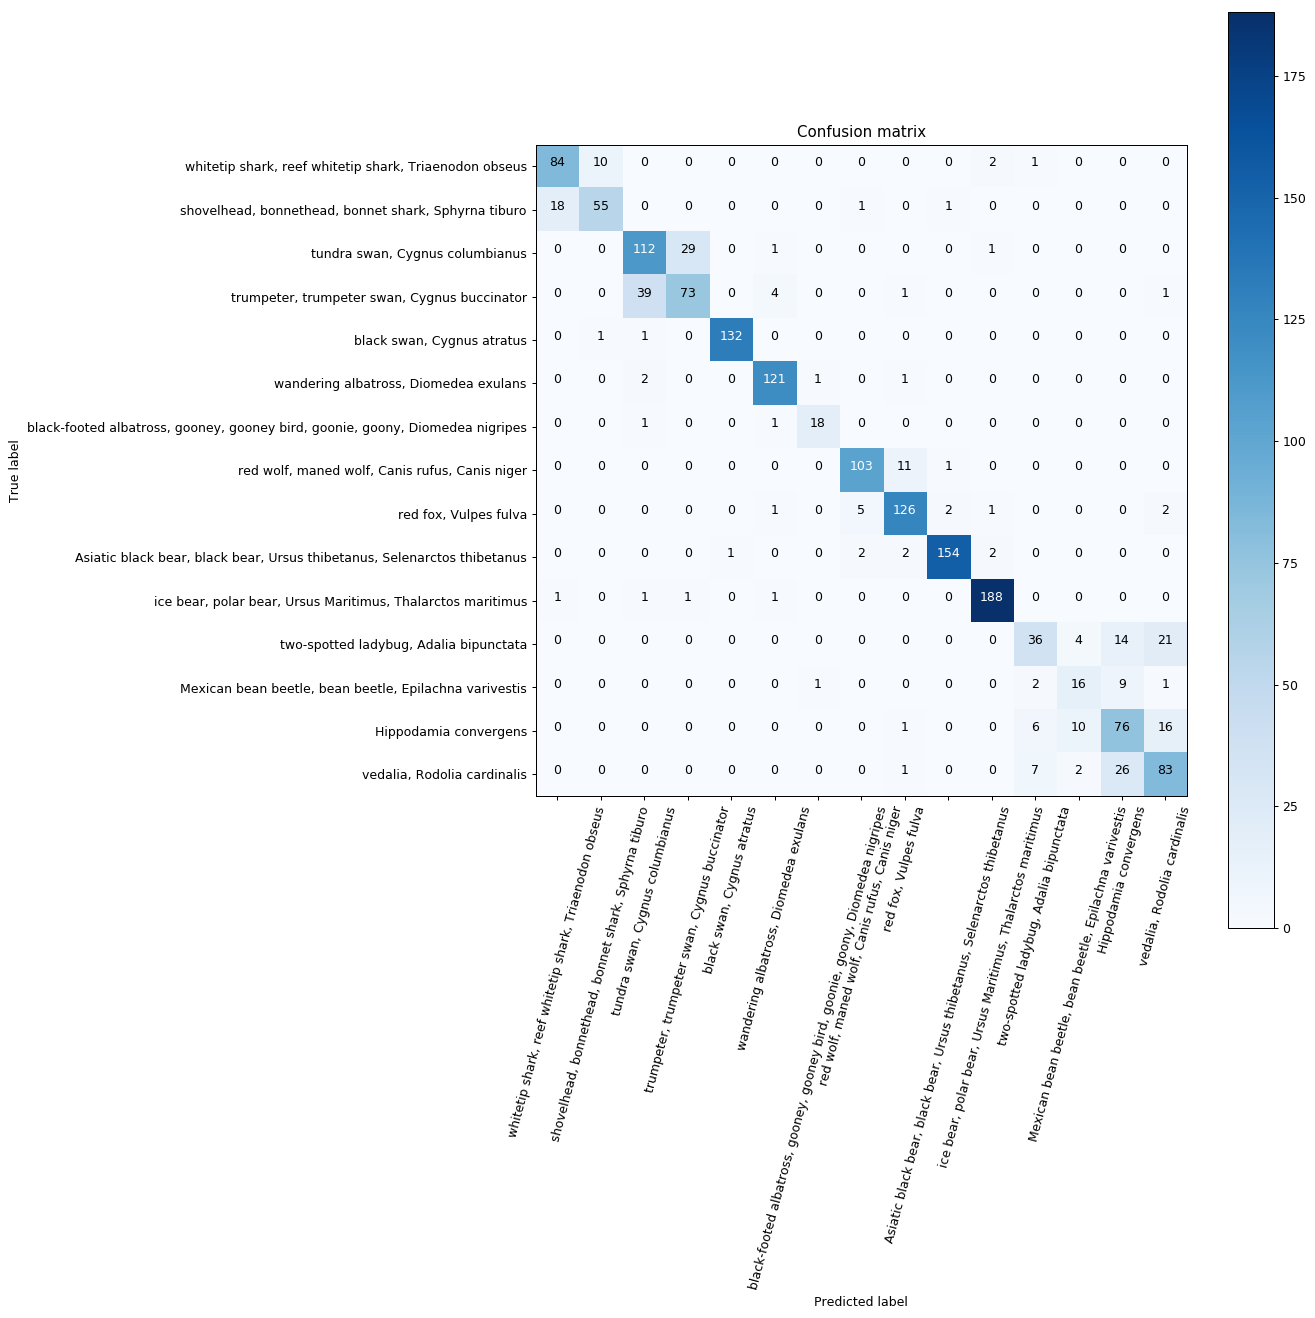

In [62]:
y_pred_categorical = DatasetProcessor.from_one_hot_to_categorical(y_pred)
y_test_categorical = DatasetProcessor.from_one_hot_to_categorical(y_test)
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_categorical, y_pred_categorical)
np.set_printoptions(precision=2)

plt.figure()
ImageProcessor.set_image_size(15, 15, 90)
classes = [wnid_to_lable[wnid] for wnid in wnids_train]
Analytics.plot_confusion_matrix(cnf_matrix, classes=list(classes), title='Confusion matrix')

## VGG16

In [ ]:
input_tensor = Input(shape=(150,150,3))
base_model = applications.VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [ ]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))

top_model.add(Dense(32))
top_model.add(BatchNormalization())
top_model.add(Activation('relu'))

top_model.add(Dense(64))
top_model.add(BatchNormalization())
top_model.add(Activation('relu'))

top_model.add(Dense(15, activation='softmax'))

In [ ]:
model = Model(input= base_model.input, output= top_model(base_model.output))

for layer in model.layers[:15]:
    layer.trainable = False
    
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../input/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../input/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=14929 // batch_size,
        epochs=1,
        validation_data=validation_generator,
        validation_steps=1649  // batch_size,
        verbose=0,
        callbacks=[TQDMNotebookCallback()])

model.save_weights('vgg16.h5')  # always save your weights after training or during training

## Pretrained convnet

In [ ]:
from keras import applications

In [ ]:
model = applications.VGG16(include_top=False, weights='imagenet')

In [ ]:
batch_size = 16

generator = datagen.flow_from_directory(
        '../input/train',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)

# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
bottleneck_features_train = model.predict_generator(generator, 14929)
# save the output as a Numpy array
np.save(open('bottleneck_features_train.npy', 'w'), bottleneck_features_train)

generator = datagen.flow_from_directory(
        '../input/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
bottleneck_features_validation = model.predict_generator(generator, 1649)
np.save(open('bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)

In [ ]:
train_data = np.load(open('bottleneck_features_train.npy'))
# the features were saved in order, so recreating the labels is easy
train_labels = np.array([0] * 1000 + [1] * 1000)

validation_data = np.load(open('bottleneck_features_validation.npy'))
validation_labels = np.array([0] * 400 + [1] * 400)

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_data, train_labels,
          epochs=50,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))
model.save_weights('bottleneck_fc_model.h5')